In [1]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload

In [3]:
% autoreload 2

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('white')
import sys
sys.path.append('/users/amyskerry/documents/projects')
from pybq import bqdf, core, util
from pybq import credentialscfg as cred

In [9]:
bqdf.cfg.DEBUG

False

In [10]:
bqdf.cfg.FETCH_BY_DEFAULT

False

#Connect to a project

In [11]:
#connect to bigquery project via project_id
con = bqdf.Connection(project_id=cred.project_id, logging_file=cred.log)

In [12]:
tables=con.list_tables('lomulation', 'temp')

Tables list:
newtable
reference_join
stats_reference
stats_reference_newcol_6156
stats_reference_newcol_8258
stats_reference_newcol_8258_newcol_1308
stats_reference_newcol_8258_newcol_8002
stats_reference_newcol_8258_newcol_8002_newcol_1577




In [13]:
for t in tables:
    if t not in ['reference_join', 'stats_reference']:
        con.delete_table('lomulation', 'temp', t)

In [14]:
#specify bq paths to tables
#format: project:dataset.tablename (if dataset is in current project_id, can use just dataset.tablename)
table1 = 'lomulation:temp.stats_reference' 
table2 = 'lomulation:temp.reference_join'

# Dataframe-ish abstraction for bigquery table

In [15]:
#create bqdf table connection
df1 = bqdf.BQDF(con, table1)
df2 = bqdf.BQDF(con, table2)

In [16]:
#these are not actually dataframes, but rather references to connected bigquery tables
#table referenced:
print df1.remote

lomulation:temp.stats_reference


In [17]:
#we can access the connection object
print df1.con

<pybq.core.Connection instance at 0x10f59ec68>


In [18]:
#which is connected to project by bq api client
print df1.con.client

In [19]:
#a local copy or sample of the data is stored in df.local
#if FETCH_BY_DEFAULT is False, local contains only a copy of the first 5 rows (the table's "head")
df1.local

,source_year,year,month,day,wday,state,is_male,child_race,weight_pounds,plurality,...,alcohol_use,drinks_per_week,weight_gain_pounds,born_alive_alive,born_alive_dead,born_dead,ever_born,father_race,father_age,record_weight
0,1969,1969,1,4,NaN,AL,True,1,6.000983,NaN,...,NaN,NaN,NaN,2,0,0,3,1,28,2
1,1969,1969,1,15,NaN,AL,True,2,6.499227,NaN,...,NaN,NaN,NaN,0,0,0,1,9,99,2
2,1969,1969,1,22,NaN,AL,True,2,8.999270,NaN,...,NaN,NaN,NaN,0,0,0,1,9,99,2
3,1969,1969,1,30,NaN,AL,True,1,7.874912,NaN,...,NaN,NaN,NaN,1,0,0,2,1,28,2
4,1969,1969,1,23,NaN,AL,True,2,8.000575,NaN,...,NaN,NaN,NaN,0,0,0,1,9,99,2


##Basic access to table data

In [20]:
#standard dataframe.head()
df1.head()

,source_year,year,month,day,wday,state,is_male,child_race,weight_pounds,plurality,...,alcohol_use,drinks_per_week,weight_gain_pounds,born_alive_alive,born_alive_dead,born_dead,ever_born,father_race,father_age,record_weight
0,1969,1969,1,4,NaN,AL,True,1,6.000983,NaN,...,NaN,NaN,NaN,2,0,0,3,1,28,2
1,1969,1969,1,15,NaN,AL,True,2,6.499227,NaN,...,NaN,NaN,NaN,0,0,0,1,9,99,2
2,1969,1969,1,22,NaN,AL,True,2,8.999270,NaN,...,NaN,NaN,NaN,0,0,0,1,9,99,2
3,1969,1969,1,30,NaN,AL,True,1,7.874912,NaN,...,NaN,NaN,NaN,1,0,0,2,1,28,2
4,1969,1969,1,23,NaN,AL,True,2,8.000575,NaN,...,NaN,NaN,NaN,0,0,0,1,9,99,2


In [39]:
#can also view schema
schema=df2.table_schema()

state (STRING) :   
gender (STRING) :   
year (INTEGER) :   
name (STRING) :   
number (INTEGER) :   


In [40]:
#get dataframe columns
df2.columns

[u'state', u'gender', u'year', u'name', u'number']

In [20]:
#get specific column values
df2['name'].values

array([u'Jennie', u'Joanna', u'Lenora', ..., u'Wendy', u'Valerie', u'Jo'], dtype=object)

In [51]:
#unique values of month
df1['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [52]:
#top most frequently occuring values in column
top=df1['month'].topk(3)
top.local

,month,count
0,3,449
1,10,443
2,6,436


In [137]:
#shape of table
df1.size

(5000, 34)

In [55]:
df1.describe()

,alcohol_use,apgar_1min,apgar_5min,born_alive_alive,born_alive_dead,born_dead,child_race,cigarette_use,cigarettes_per_day,day,...,mother_age,mother_birth_state,mother_race,plurality,record_weight,source_year,wday,weight_gain_pounds,weight_pounds,year
count,0,0,0,4997.000000,4994.000000,4993.000000,5000.000000,0,0,5000.000000,...,5000.000000,0,5000.00000,0,5000,5000,0,0,4963.000000,5000
min,NaN,NaN,NaN,0.000000,0.000000,0.000000,1.000000,NaN,NaN,1.000000,...,13.000000,NaN,1.00000,NaN,2,1969,NaN,NaN,0.687842,1969
25th percentile,NaN,NaN,NaN,0.000000,0.000000,0.000000,1.000000,NaN,NaN,8.000000,...,20.000000,NaN,1.00000,NaN,2,1969,NaN,NaN,6.437498,1969
50th percentile,NaN,NaN,NaN,1.000000,0.000000,0.000000,1.000000,NaN,NaN,15.000000,...,23.000000,NaN,1.00000,NaN,2,1969,NaN,NaN,7.187070,1969
75th percentile,NaN,NaN,NaN,2.000000,0.000000,0.000000,1.000000,NaN,NaN,22.000000,...,27.000000,NaN,1.00000,NaN,2,1969,NaN,NaN,7.874912,1969
max,NaN,NaN,NaN,77.000000,77.000000,77.000000,9.000000,NaN,NaN,99.000000,...,48.000000,NaN,9.00000,NaN,2,1969,NaN,NaN,13.999354,1969
mean,NaN,NaN,NaN,1.780668,1.138366,1.258362,1.333200,NaN,NaN,15.615200,...,24.578600,NaN,1.32200,NaN,2,1969,NaN,NaN,7.192860,1969
std,NaN,NaN,NaN,5.773542,8.320288,8.462383,0.978146,NaN,NaN,8.918847,...,5.693356,NaN,0.96649,NaN,0,0,NaN,NaN,1.301148,0
mode,NaN,NaN,NaN,0.000000,0.000000,0.000000,1.000000,NaN,NaN,15.000000,...,21.000000,NaN,1.00000,NaN,2,1969,NaN,NaN,6.999677,1969


## Basic summary operations over columns

In [59]:
df1['weight_pounds'].mean()

7.1928600405858019

In [60]:
df1['weight_pounds'].std()

1.301147609224462

In [65]:
df1['weight_pounds'].sem()

0.018469469888195051

In [61]:
df1['weight_pounds'].max()

13.999353637

In [62]:
df1['weight_pounds'].min()

0.68784225743999994

In [63]:
df1['weight_pounds'].sum()

35698.164381427334

In [66]:
df1['month'].mode()

3

## Row-based operations

In [67]:
zscored=df1['weight_pounds'].zscore()
zscored.local

,zscore
0,-0.916020
1,-0.533093
2,1.388320
3,0.524193
4,0.620772


In [69]:
sqrt=df1['weight_pounds'].sqrt()
sqrt.local

,sqrt
0,2.449690
1,2.549358
2,2.999878
3,2.806227
4,2.828529


In [70]:
log = df1['weight_pounds'].log()
log.local

,log
0,1.791923
1,1.871683
2,2.197143
3,2.063682
4,2.079513


In [72]:
rounded = df1['weight_pounds'].round(dig=2)
rounded.local

,round
0,6.00
1,6.50
2,9.00
3,7.87
4,8.00


## Manipulating table data

In [73]:
df1.add_index(inplace=True)

In [74]:
df1.head()

,index,source_year,year,month,day,wday,state,is_male,child_race,weight_pounds,...,alcohol_use,drinks_per_week,weight_gain_pounds,born_alive_alive,born_alive_dead,born_dead,ever_born,father_race,father_age,record_weight
0,1,1969,1969,1,4,NaN,AL,True,1,6.000983,...,NaN,NaN,NaN,2,0,0,3,1,28,2
1,2,1969,1969,1,15,NaN,AL,True,2,6.499227,...,NaN,NaN,NaN,0,0,0,1,9,99,2
2,3,1969,1969,1,22,NaN,AL,True,2,8.999270,...,NaN,NaN,NaN,0,0,0,1,9,99,2
3,4,1969,1969,1,30,NaN,AL,True,1,7.874912,...,NaN,NaN,NaN,1,0,0,2,1,28,2
4,5,1969,1969,1,23,NaN,AL,True,2,8.000575,...,NaN,NaN,NaN,0,0,0,1,9,99,2


In [75]:
del df1['index']

In [95]:
#return table with subset of columns
limited=df1[['day', 'year', 'state', 'is_male']]

In [96]:
#will inherit fetch status of the source (e.g. since df1.fetched=False, limited is not fetched locally)
len(limited.local)

5

In [97]:
#but we can explicitly fetch the data
limited.fetch()

Number of rows in remote table exceeds bqdf object's max_rows. Only max_rows have been fetched locally


In [98]:
len(limited.local)

5000

In [79]:
#add column with value
df1.add_col('test1', 100)

/users/amyskerry/documents/projects/pybq/bqdf.py:604: UserWarning: No expiration set
  warnings.warn("No expiration set")


In [100]:
#add column with local list/array
df1.add_col('test2', [np.random.randint(1000) for i in range(len(df1))])

/users/amyskerry/documents/projects/pybq/bqdf.py:604: UserWarning: No expiration set
  warnings.warn("No expiration set")


In [101]:
#add column with local list/array
df1.add_col('normalized_weight', df1['weight_pounds'].zscore())

In [103]:
df1[['test1', 'test2', 'normalized_weight', 'weight_pounds']].head()

,test1,test2,normalized_weight,weight_pounds
0,100,489,-0.916020,6.000983
1,100,641,-0.533093,6.499227
2,100,273,1.388320,8.999270
3,100,169,0.524193,7.874912
4,100,491,0.620772,8.000575


In [104]:
newdf=limited.local
newdf['gender']=newdf['is_male'].apply(lambda x: 'Male 'if x else 'Female')

In [110]:
newdf.head()

,day,year,state,is_male,gender
0,4,1969,AL,True,Male
1,15,1969,AL,True,Male
2,22,1969,AL,True,Male
3,30,1969,AL,True,Male
4,23,1969,AL,True,Male


In [111]:
_=core.write_df_to_remote(con, 'lomulation', 'temp', 'newtable', newdf)

## Operations on pairs of columns

In [113]:
df1.dot('month', 'weight_pounds')

234266.48007965862

In [115]:
df1.cos('day', 'weight_pounds')

0.85775406307842916

In [116]:
df1.corr('month', 'weight_pounds')

0.039757234078351092

In [117]:
df1.euclidean('month', 'weight_pounds')

258.95662187561317

In [135]:
mat=df1.contingency_mat('month', 'day')
mat

Number of rows in remote table exceeds bqdf object's max_rows. Only max_rows have been fetched locally


day,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,99
month,,,,,,,,,,,,,,,,,,,,,
1,10,9,12,12,12,13,8,11,13,13,...,15,15,14,13,10,10,14,13,14,NaN
2,9,18,14,17,18,14,13,18,8,15,...,12,12,27,18,8,9,NaN,NaN,1,1
3,14,10,13,22,14,12,15,11,21,17,...,14,19,16,11,15,18,10,5,16,NaN
4,14,13,12,7,11,8,22,16,14,11,...,8,12,13,5,9,12,14,13,NaN,NaN
5,11,18,19,11,18,13,7,18,12,11,...,12,12,13,10,13,8,14,5,17,1
6,16,12,17,15,10,17,17,8,13,10,...,17,9,7,16,14,21,11,13,1,NaN
7,14,11,19,8,12,11,16,17,18,18,...,14,14,27,10,10,18,12,12,12,NaN
8,13,9,14,24,17,12,16,10,13,10,...,12,12,9,10,10,25,10,19,11,NaN
9,14,13,18,11,13,11,11,15,16,15,...,18,19,14,14,12,11,16,10,NaN,NaN


In [138]:
corrmat=df1.corr_mat()

KeyboardInterrupt: 

## Joining and filtering

In [46]:
# df.where is used for filtering the table.
# each condition is expressed as it's own string argument
# only simple equality, greater than, less than are currently supported
print len(df1)
ndf = df1.where('day>4')
print len(ndf.local)
ndf = df1.where('num_comments>4', 'score <6', fetch=True)
print len(ndf.local)

Waiting on bqjob_r61976833b7cb662_0000014e9bfb87ba_142 ... (0s) Current status: DONE   
Waiting on bqjob_rc38fd243c733d71_0000014e9bfb8a7f_143 ... (0s) Current status: DONE   
Waiting on bqjob_r1d21abb42829bd6a_0000014e9bfb9187_144 ... (0s) Current status: DONE   
2499
Waiting on bqjob_r3790a9dd31000fcf_0000014e9bfb94ef_145 ... (0s) Current status: DONE   
Waiting on bqjob_r410ac9b5d73cdf3a_0000014e9bfb9c4d_146 ... (0s) Current status: DONE   
Waiting on bqjob_re236457da2448d6_0000014e9bfb9f2c_147 ... (0s) Current status: DONE   
21
Waiting on bqjob_r30ce2d0578cda824_0000014e9bfba6f3_148 ... (0s) Current status: DONE   
Waiting on bqjob_r243ede896fed1ab8_0000014e9bfbaeef_149 ... (0s) Current status: DONE   
Waiting on bqjob_r6dd12035ca3ec4dd_0000014e9bfbb70f_150 ... (0s) Current status: DONE   
6


In [106]:
#join two tables
#note this returns a new BQDF object with a reference to the resulting table
ndf=df1.join(df2, on='subr', how='inner', fetch=True)

fetching from local cache
Waiting on bqjob_r35b2fe3937ba5d6c_0000014e9c0e362d_327 ... (0s) Current status: DONE   
fetching from local cache


In [48]:
#references temporary table created by query
ndf.remote

u'[durable-footing-95814:_7f939837d73fe18145c1d220d8cea862f339ce2f.anon28b5b8b485f49cb4a4e98c0050fc19ad20099d86]'

In [49]:
#because fetch was set to True, remote table was fetched to ndf.local
ndf.local

,df1_subr,df1_created_utc,df1_score,df1_num_comments,df1_c_posts,df1_ups,df1_downs,df2_subr,df2_sum_score
0,worldnews,1245520828,2876818,1520393,1000,12232641,9355823,worldnews,2876818
1,WTF,1222835012,2665757,1138484,1000,15478789,12813032,WTF,2665757
2,funny,1221430088,3713684,838031,1000,29943636,26229952,funny,3713684
3,gaming,1253397497,2633408,976844,1000,16049758,13416350,gaming,2633408
4,gifs,1308299210,2615749,267366,1000,11088214,8472465,gifs,2615749
5,mildlyinteresting,1339002701,2487454,220753,1000,7632646,5145192,mildlyinteresting,2487454
6,cringepics,1353378477,2320307,310899,999,4956013,2635706,cringepics,2320307
7,pics,1232129032,3752388,1119747,1000,28512455,24760067,pics,3752388
8,politics,1213054866,3157350,1529645,999,12994846,9837496,politics,3157350
9,reactiongifs,1329098282,2320331,127718,1000,5915530,3595199,reactiongifs,2320331


## More flexible querying

In [107]:
#execute arbitrary sql commands and return as df and source
#note: raw_query does not return a BQDF object
querystr = """
SELECT subr, num_comments, score, c_posts FROM %s  LIMIT 1000
""" %table1
df, source = bqdf.raw_query(con, querystr)

Waiting on bqjob_r32bde585b7276dcb_0000014e9c0e7d6c_328 ... (0s) Current status: DONE   


In [53]:
df.head()

,subr,num_comments,score,c_posts
0,Winnipeg,23782,35017,1000
1,winterporn,1858,61256,1000
2,wisconsin,24893,71500,999
3,woahdude,126829,2089822,1000
4,women,12128,63478,1000


##Plotting

In [ ]:
#create a histogram of a column's values
histdf=df1['weight_pounds'].hist(bins=20)

In [141]:
#create a simple plot (mean +/- 1 SEM) of value_col, broken down by grouping_col
value_col='weight_pounds'
grouping_col='month'
df1.plot(grouping_col, value_col, kind='bar')

KeyboardInterrupt: 

Waiting on bqjob_r5446ea84859d2408_0000014e9c108526_339 ... (0s) Current status: DONE   
0.000267028808594
Waiting on bqjob_r254a7a18c87ae0a3_0000014e9c108822_340 ... (0s) Current status: DONE   
Waiting on bqjob_r13cbc6b92c94b718_0000014e9c108b40_341 ... (0s) Current status: DONE   
0.00558471679688
Waiting on bqjob_r470bd9571cb96a81_0000014e9c109321_342 ... (0s) Current status: DONE   
0.0102310180664
Waiting on bqjob_r70edbaee454db3dc_0000014e9c1099ca_343 ... (0s) Current status: DONE   
Waiting on bqjob_r68e0ea3c6440532a_0000014e9c10a133_344 ... (0s) Current status: DONE   
0.0151901245117


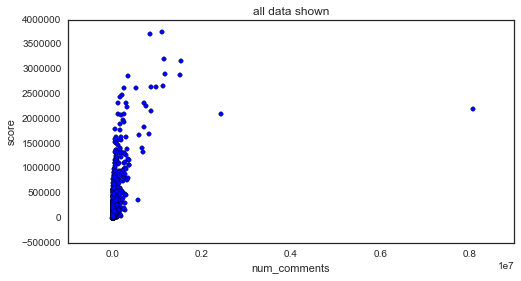

In [114]:
#create scatter plot of x vs. y (since bins > total number of datapoints, will plot all data)
scatterseries=df1.scatter('weight_pounds', 'day', bins=1000)

Waiting on bqjob_r57465fd7070b45b_0000014e9bfcca94_175 ... (0s) Current status: DONE   
Waiting on bqjob_r5c068c203eb4093c_0000014e9bfccd5a_176 ... (0s) Current status: DONE   
Waiting on bqjob_r8ffe5f69ef98ff9_0000014e9bfcd244_177 ... (0s) Current status: DONE   
Waiting on bqjob_r449e1df5c4378473_0000014e9bfcd989_178 ... (0s) Current status: DONE   
query saved to durable-footing-95814:_7f939837d73fe18145c1d220d8cea862f339ce2f.anon95ee7e5b5fafebb5e597a3541b0640d971cc0d93
returning head only
Waiting on bqjob_r185516469de6755b_0000014e9bfcdcb6_179 ... (0s) Current status: DONE   
Waiting on bqjob_r143c60795e77f250_0000014e9bfce3e6_180 ... (0s) Current status: DONE   
Waiting on bqjob_r2fa60537e947ca0c_0000014e9bfceb68_181 ... (0s) Current status: DONE   
query saved to durable-footing-95814:_7f939837d73fe18145c1d220d8cea862f339ce2f.anon58daa3ca68c9e2778f67288fe354a2d0260271f1
returning head only
Waiting on bqjob_r63168006009c68a8_0000014e9bfcedcc_182 ... (0s) Current status: DONE   
Wa

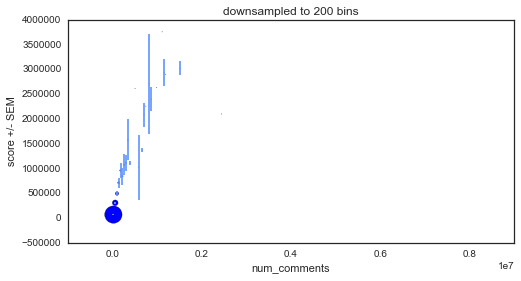

In [60]:
#create a downsampled scatter plot of x vs. y
plotdf=df1.scatter('weight_pounds', 'day', bins=200)

## Misc

In [ ]:
projects=con.list_all_projects()
datasets=con.list_datasets('lomulation') 
tables=con.list_tables('lomulation', 'temp')

##ToDo

fix all the things

In [24]:
temp=df1[['year', 'state', 'child_race']]

In [25]:
temp.remote

u'lomulation:_7f939837d73fe18145c1d220d8cea862f339ce2f.anon64e767e72a566d73338928ae184945a8b2d53e24'

In [30]:
int(temp.resource['expirationTime'])-int(temp.resource['creationTime'])

86400005

In [37]:
datetime.datetime.fromtimestamp(int(temp.resource['expirationTime'][:10]))

datetime.datetime(2015, 8, 10, 10, 29, 42)

In [38]:
datetime.datetime.fromtimestamp(int(temp.resource['creationTime'][:10]))

datetime.datetime(2015, 8, 9, 10, 29, 42)

In [39]:
temp.creation_time

2015-08-09 10:29:42.345000


In [40]:
temp.expiration_time

2015-08-10 10:29:42.350000
